# Real data

In this notebook we will test active learning on real world imbalanced data.

In [3]:
## Imports ##

# numpy
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import MISSING_LABEL

# plot function
from plot_accuracy import plot_accuracy

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

## [Breast cancer wisconsin](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

Wolberg,William, Mangasarian,Olvi, Street,Nick, and Street,W.. (1995). Breast Cancer Wisconsin (Diagnostic). UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.

The breast cancer data set is publicly available, we can just import it.

In [4]:
# import the data set
from ucimlrepo import fetch_ucirepo 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

In [5]:
# load the data once
X_data = breast_cancer_wisconsin_diagnostic.data.features
y_data = list(breast_cancer_wisconsin_diagnostic.data.targets['Diagnosis'])
y_data = [0 if x == 'B' else 1 for x in y_data]

# get indexes of both the types and make them balanced
bIdx = [i for i in range(len(y_data)) if y_data[i] == 0]
mIdx = [i for i in range(len(y_data)) if y_data[i] == 1]
bIdx = bIdx[:len(mIdx)]

# get weighted data by undersampling
def trimmed_data(weight_b=0.5):
    # get the length of the index list for the weight
    b_len = len(mIdx)
    m_len = len(mIdx)
    weight_m = 1 - weight_b
    if weight_b > 0.5:
        m_len = (b_len*weight_m)/weight_b
    else:
        b_len = (m_len*weight_b)/weight_m

    selected_idx = bIdx[:int(b_len)] + mIdx[:int(m_len)]
    X = X_data.loc[selected_idx]
    y = [y_data[i] for i in selected_idx]

    return train_test_split(X, y, random_state=1, test_size=0.5)

357
212


In [6]:
def al(weight_b=-1, cycles=50, random_state=0, per_class=False):
    if weight_b == -1:
        Xf, Xt, yf, yt = train_test_split(X_data, y_data, random_state=1, test_size=0.5)
    else:
        Xf, Xt, yf, yt = trimmed_data(weight_b=weight_b)
    qs = UncertaintySampling(random_state=random_state)
    clf = SklearnClassifier(LogisticRegression(), classes=np.unique(yf), random_state=random_state)
    y = np.full(shape=len(yf), fill_value=MISSING_LABEL)

    # perform active learning
    out = []
    clf.fit(Xf,y)
    for _ in range(cycles):
        i = qs.query(Xf, y, clf)[0]
        y[i] = yf[i]
        clf.fit(Xf,y)
        counts = balanced_accuracy(yt,clf.predict(Xt), as_counters=True)
        b_acc = counts[1][0]/counts[0][0]
        m_acc = counts[1][1]/counts[0][1]
        if per_class:
            out.append((b_acc, m_acc))
        else:
            out.append((b_acc+m_acc)/2)
    return out

In [7]:
def plot_percentages(data, weight_b, ax):
    data = np.array([[tn, tp, 1-tn, 1-tp] for (tn, tp) in data]).transpose()
    x = np.arange(len(data[0]))
    names = ['True benign', 'True malignant', 'False malignant', 'False benign']
    for i, name in enumerate(names):
        ax.plot(x, data[i], label=name)
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Samples asked at oracle')
    ax.set_title(f'Imbalanced: B={int(weight_b*100)}%, M={int((1-weight_b)*100)}%')
    ax.legend()

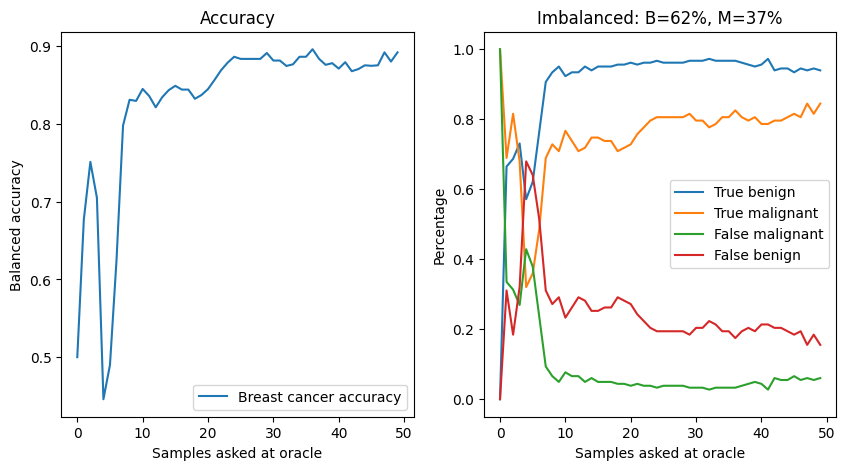

In [8]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot_percentages(al(cycles=50, per_class=True), 0.62741652, axs[1])
plot_accuracy('Accuracy', [[al(cycles=50), 'Breast cancer accuracy']], axs[0])

We can see that our uncertainty sampling performs rather well even on a real world data set. Something interesting to note is that the minority class gets a worse accuracy.

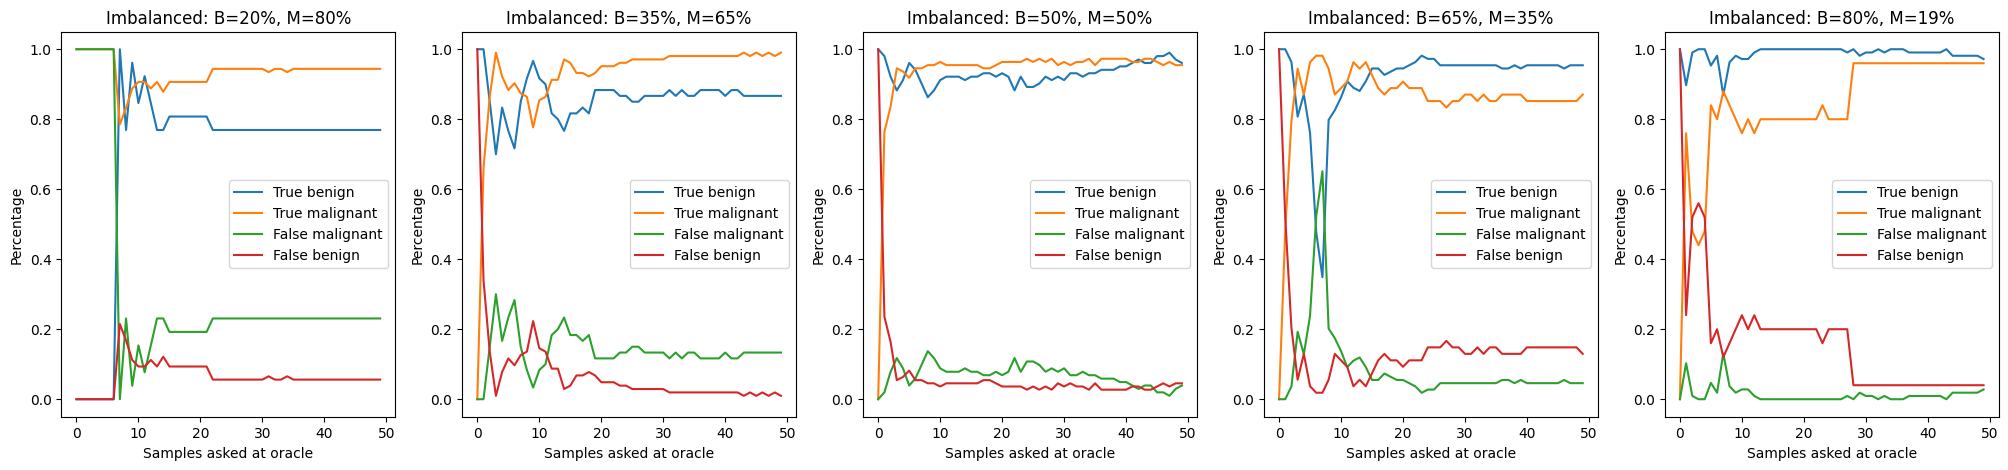

In [9]:
weights = [0.2, 0.35, 0.5, 0.65, 0.8]
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
for i, weight_b in enumerate(weights):
    plot_percentages(al(weight_b=weight_b, cycles=50, per_class=True), weight_b, axs[i])


In the above experiment we checked the influence of imbalanced data on false benign and malignant results. When getting medical results it is desired to get `True benign` or `True malignant` results. This means that the result of the test is correct. If the test is `False malignant` it says we have breast cancer when we don't have it. This is annoying, but is still fine, since further inquiry will see that we don't have cancer. However if the test says `False benign` we get the feeling that we are safe, and are less inclined to do further testing. This is dangerous and should be avoided.

In our results the green line indicates `False benign`. B stands for non cancer cells and M stand for cancer cells. We see that when we have less non cancer cells our `False benign` rate rises. We can conclude that the minority class will have a worse accuracy. This means a higher chance of False results of that class and a lower chance of True results of that class.